In [11]:
!pip install split-folders

In [2]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile
from PIL import Image
from tensorflow.keras import layers, models, metrics, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

In [3]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
set_seeds()
print("Environment setup complete. TensorFlow version:", tf.__version__)

Environment setup complete. TensorFlow version: 2.19.0


In [6]:
with open("kaggle.json") as f:
    kaggle_credentials = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

In [7]:
if not os.path.exists("plantvillage-dataset.zip"):
    print("Downloading dataset...")
    os.system("kaggle datasets download -d abdallahalidev/plantvillage-dataset")
else:
    print("Dataset zip already exists.")
if not os.path.exists("plantvillage dataset"):
    with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
        zip_ref.extractall()
    print("Extraction complete.")

Extraction complete.


In [8]:
base_dir = 'plantvillage dataset/color'
output_dir = "dataset_split"

In [12]:
import splitfolders
if not os.path.exists(output_dir):
    splitfolders.ratio(base_dir, output=output_dir, seed=40, ratio=(.8, .1, .1))

Copying files: 54305 files [00:12, 4476.09 files/s]


In [13]:
# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [14]:
# Augmentation for Training to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
# Only rescaling for Validation and Testing
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 43429 images belonging to 38 classes.


In [17]:
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 5417 images belonging to 38 classes.


In [18]:
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5459 images belonging to 38 classes.


In [19]:
def build_plant_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the early feature-extraction layers
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(), # Stabilizes learning
        layers.Dropout(0.5),         # Reduces overfitting
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')]
    )
    return model



In [20]:
num_classes = len(train_generator.class_indices)
model = build_plant_model(num_classes)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,600,806 (9.92 MB)

 Trainable params: 2,201,702 (8.40 MB)

 Non-trainable params: 399,104 (1.52 MB)

In [21]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

In [22]:
history = model.fit(
    train_generator,
    epochs=10, # Increased epochs as EarlyStopping will catch the peak
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 645s 451ms/step - accuracy: 0.6811 - loss: 1.2595 - precision: 0.8591 - recall: 0.5975 - val_accuracy: 0.8887 - val_loss: 0.3766 - val_precision: 0.9068 - val_recall: 0.8783 - learning_rate: 1.0000e-04
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 541s 399ms/step - accuracy: 0.9405 - loss: 0.1791 - precision: 0.9533 - recall: 0.9305 - val_accuracy: 0.9533 - val_loss: 0.1473 - val_precision: 0.9580 - val_recall: 0.9509 - learning_rate: 1.0000e-04
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 533s 393ms/step - accuracy: 0.9585 - loss: 0.1249 - precision: 0.9651 - recall: 0.9534 - val_accuracy: 0.9531 - val_loss: 0.1410 - val_precision: 0.9590 - val_recall: 0.9511 - learning_rate: 1.0000e-04
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 535s 394ms/step - accuracy: 0.9704 - loss: 0.0901 - precision: 0.9740 - recall: 0.9675 - val_accuracy: 0.9734 - val_loss: 0.0821 - val_precision: 0.9759 - val_recall: 0.9723 - learning_rate: 1.0000e-04
Epoch 5/10
1358/1358 ━━━

In [23]:
model.save('plant_disease_model.keras')
with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

In [24]:
def get_metrics_summary(model, generator, dataset_name):

    results = model.evaluate(generator, verbose=0)
    loss = results[0]
    acc  = results[1]
    prec = results[2]
    rec  = results[3]

    f1 = 2 * (prec * rec) / (prec + rec + 1e-7)

    return {
        "Dataset": dataset_name,
        "Loss": f"{loss:.4f}",
        "Accuracy": f"{acc*100:.2f}%",
        "Precision": f"{prec:.4f}",
        "Recall": f"{rec:.4f}",
        "F1-Score": f"{f1:.4f}"
    }

# Collect results
summary_data = [
    get_metrics_summary(model, train_generator, "TRAIN"),
    get_metrics_summary(model, val_generator, "VALIDATION"),
    get_metrics_summary(model, test_generator, "TEST")
]

# Print a formatted table
print(f"{'Dataset':<12} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
print("-" * 65)
for data in summary_data:
    print(f"{data['Dataset']:<12} | {data['Accuracy']:<10} | {data['Precision']:<10} | {data['Recall']:<10} | {data['F1-Score']:<10}")

Dataset      | Accuracy   | Precision  | Recall     | F1-Score  
-----------------------------------------------------------------
TRAIN        | 99.68%     | 0.9970     | 0.9968     | 0.9969    
VALIDATION   | 99.04%     | 0.9915     | 0.9902     | 0.9909    
TEST         | 99.05%     | 0.9912     | 0.9897     | 0.9905    


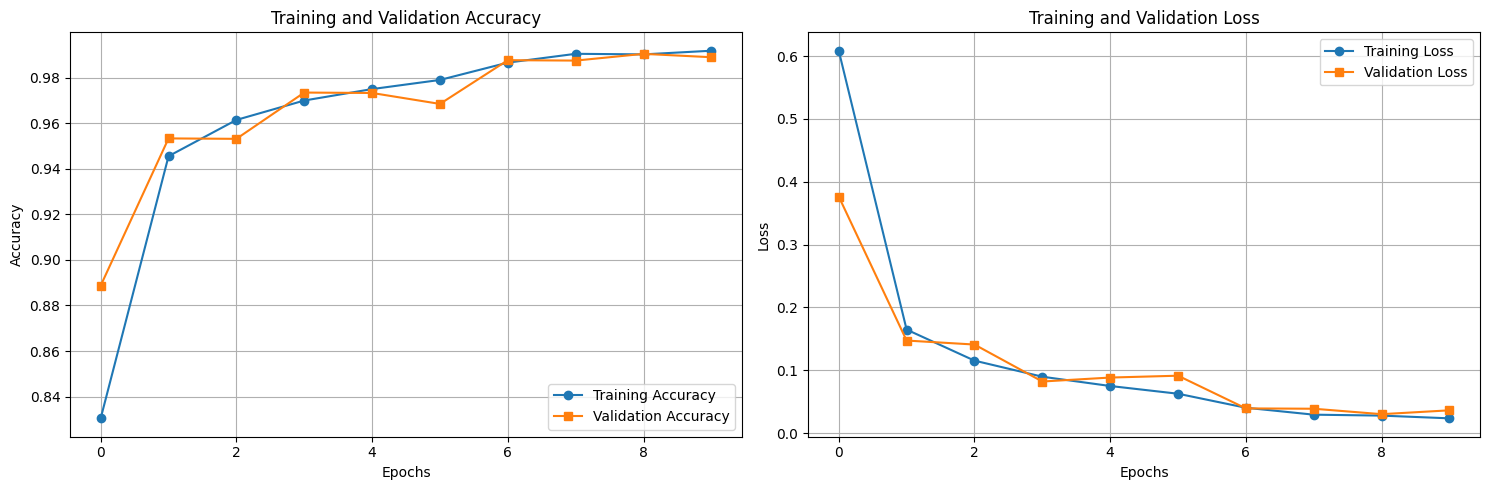

In [25]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Generating predictions for the test set...
171/171 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step

--- Classification Report ---
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      1.00      0.99        63
                                 Apple___Black_rot       1.00      1.00      1.00        63
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        28
                                   Apple___healthy       0.99      0.99      0.99       165
                               Blueberry___healthy       1.00      1.00      1.00       151
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       106
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        86
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.88      0.88      0.88        52
                       Corn_(maize)___Common_rust_    

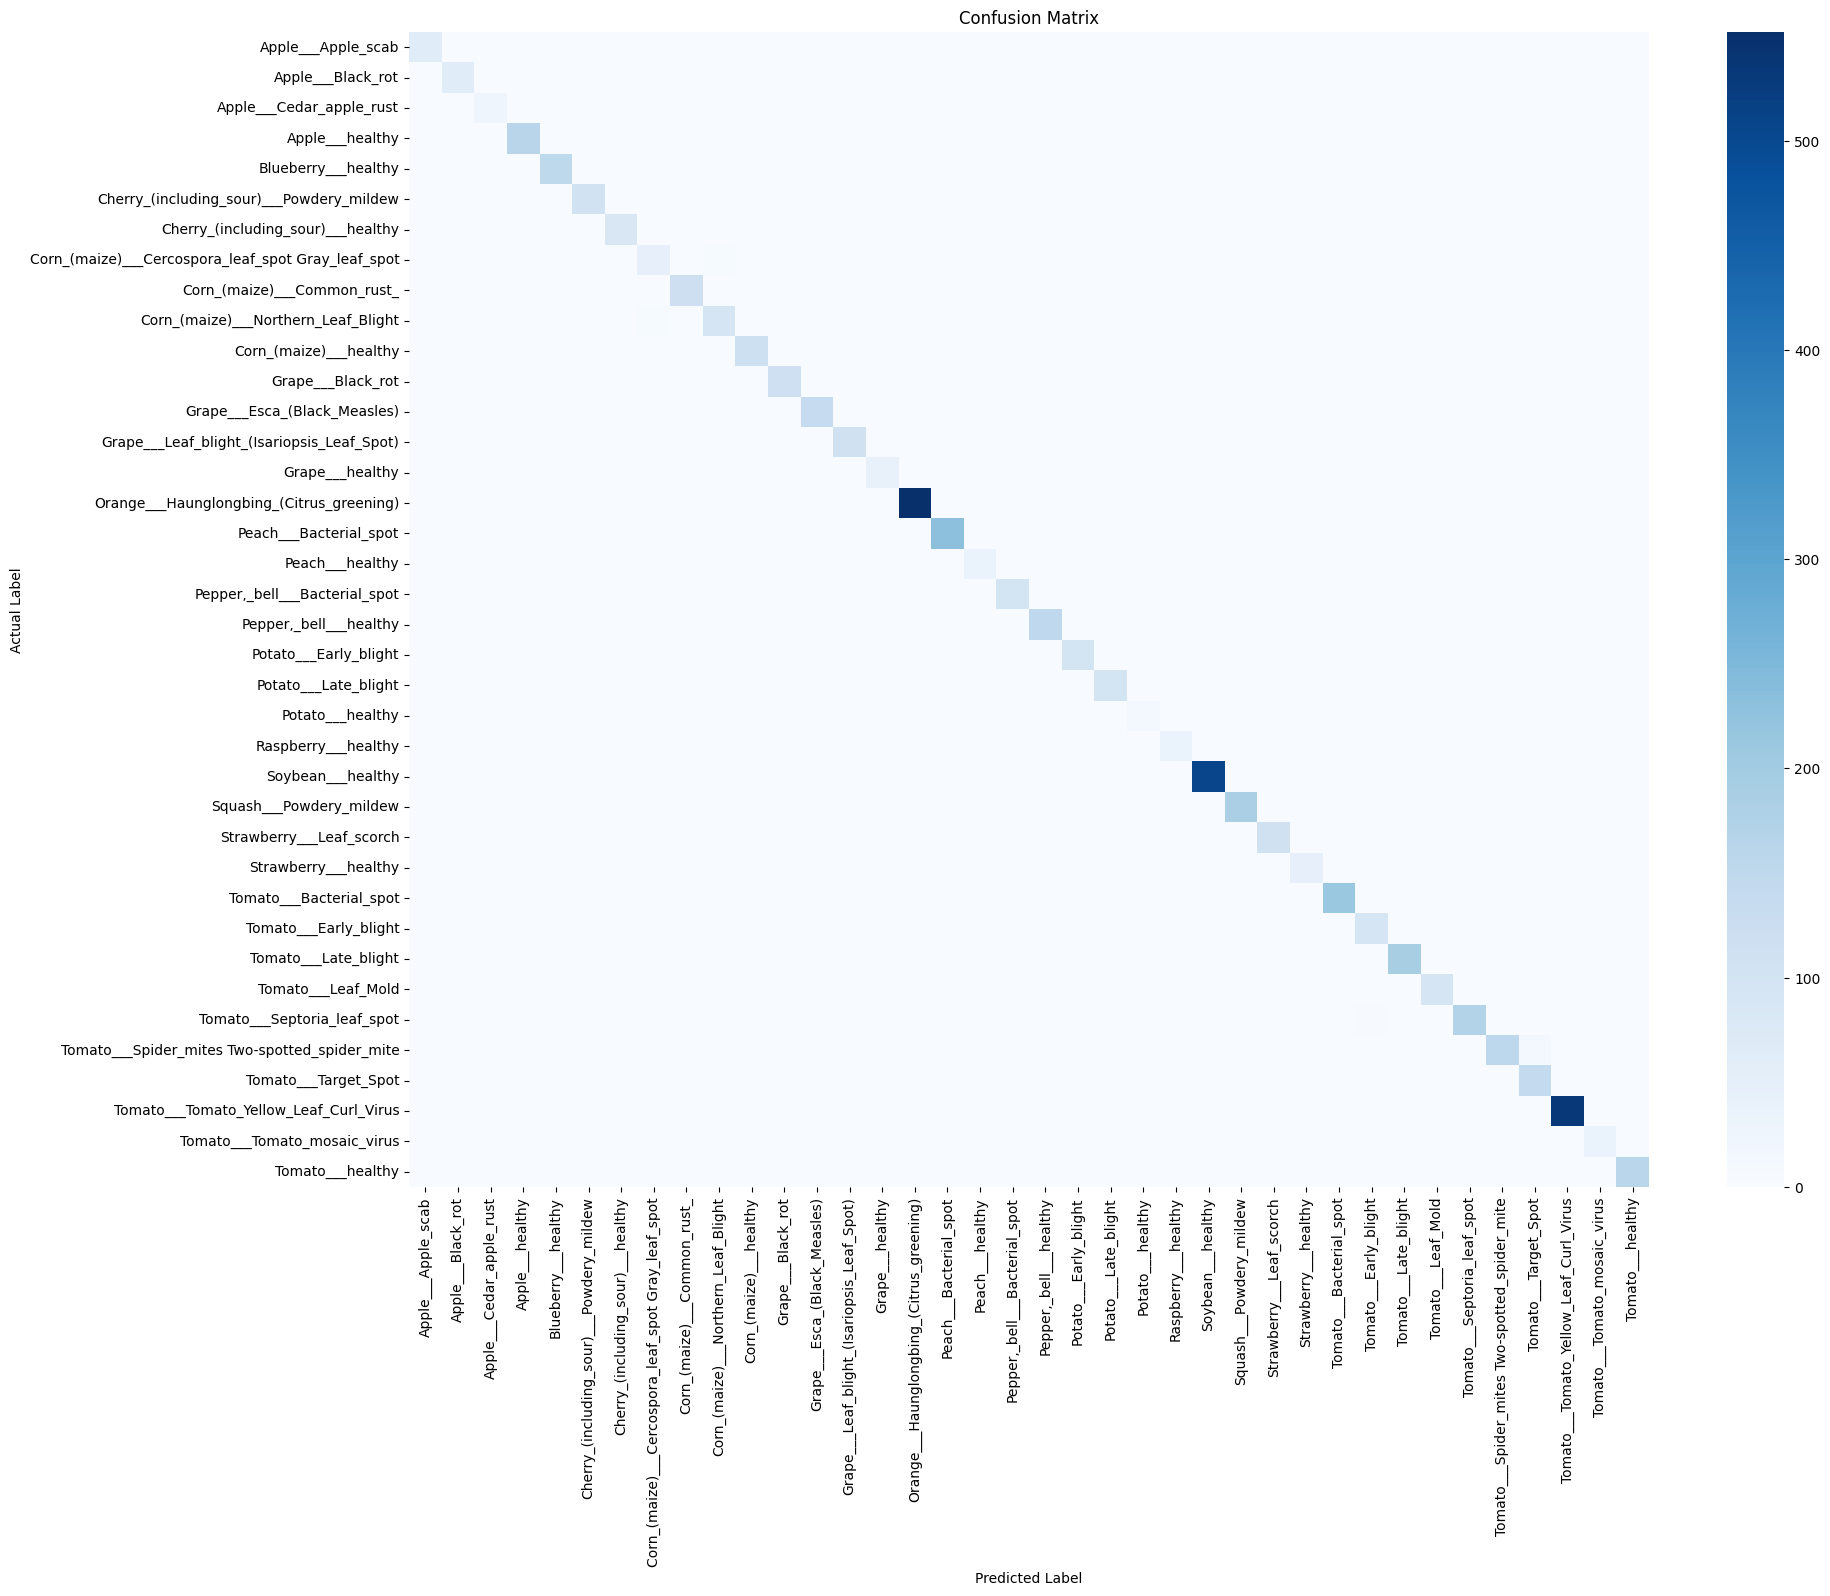

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model_detailed(model, test_gen):
    # 1. Get Predictions
    print("Generating predictions for the test set...")
    test_gen.reset() # Ensure we start from the beginning
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    # 2. Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # 3. Confusion Matrix Visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.show()

# Run evaluation on the test set
evaluate_model_detailed(model, test_generator)

In [27]:
def predict_and_verify(image_path, model, class_indices):
    # Process Image
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    idx = np.argmax(predictions[0])
    confidence = predictions[0][idx]

    # Map index to Name
    inv_map = {v: k for k, v in class_indices.items()}
    class_name = inv_map[idx]

    print(f"Prediction: {class_name} ({confidence*100:.2f}%)")
    if confidence < 0.60:
        print("⚠️ Warning: Low confidence. Please verify with a clearer photo.")

    return class_name, confidence


In [28]:
result = predict_and_verify('/content/dataset_split/test/Grape___Esca_(Black_Measles)/0db65255-6c76-4685-93fe-2967f9040e78___FAM_B.Msls 1176.JPG', model, train_generator.class_indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Prediction: Grape___Esca_(Black_Measles) (100.00%)
